In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline


In [29]:
def generate_brownian_motion(n_steps=500, dt=1.0, sigma=1.0):
    increments = np.random.normal(0, np.sqrt(dt) * sigma, n_steps)
    return np.cumsum(increments)

def generate_geometric_brownian_motion(n_steps=500, mu=0.1, sigma=0.2, S0=100.0, dt=1.0):
    S = np.zeros(n_steps)
    S[0] = S0
    for t in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW)
    return S

def generate_ou_process(n_steps=500, theta=1.0, mu=0.0, sigma=0.3, X0=0.0, dt=0.1):
    X = np.zeros(n_steps)
    X[0] = X0
    for t in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * dW
    return X


In [189]:
def create_lagged_dataset(data, lags=15):
    df = pd.DataFrame({'value': data})
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['value'].shift(i)
    df.dropna(inplace=True)
    X = df.drop('value', axis=1)
    y = df['value']
    return X, y, df.index


def smooth_series(data, alpha=0.2):
    return pd.Series(data).ewm(alpha=alpha, adjust=False).mean().values


def create_feature_dataset_with_history(train_data,
                                        test_data, 
                                        windows=[5,10,25,50],
                                        mode="raw",
                                        smoothing_alpha=0.2):

    if mode == "smooth":
        train_used = smooth_series(train_data, smoothing_alpha)
    else:
        train_used = train_data.copy()

    df = pd.DataFrame({"value": np.concatenate([train_used, test_data])})

    df["lag_1"] = df["value"].shift(1)

    for w in windows:
        df[f"mean_{w}"] = df["value"].rolling(w).mean()
        df[f"min_{w}"]  = df["value"].rolling(w).min()
        df[f"max_{w}"]  = df["value"].rolling(w).max()
        df[f"var_{w}"]  = df["value"].rolling(w).var()
        df[f"ema_{w}"]  = df["value"].ewm(alpha=0.3).mean()
        df[f"lag_{w}"] = df["value"].shift(w)

    df.dropna(inplace=True)

    test_start = len(train_data)
    
    train_df = df.iloc[df.index < test_start]
    test_df  = df.iloc[df.index >= test_start]

    X_train = train_df.drop("value", axis=1)
    y_train = train_df["value"]

    X_test = test_df.drop("value", axis=1)
    y_test = test_df["value"]

    return X_train, y_train, X_test, y_test


def simulate_trading(actual_prices, predicted_prices):
    profits = []
    for i in range(len(actual_prices) - 1):
        current = actual_prices[i]
        pred_next = predicted_prices[i]
        actual_next = actual_prices[i + 1]
        
        if pred_next > current:
            profit = actual_next - current
        elif pred_next < current:
            profit = current - actual_next
        else:
            profit = 0
        profits.append(profit)
    
    return np.sum(profits), profits

def simulate_trading(actual_prices, predicted_prices):
    profits = []
    errors_abs = []
    errors_sq = []
    errors = []
    for i in range(len(actual_prices) - 1):
        current = actual_prices[i]
        pred_next = predicted_prices[i]
        actual_next = actual_prices[i + 1]

        if pred_next > current:
            profit = actual_next - current
        elif pred_next < current:
            profit = current - actual_next
        else:
            profit = 0
        profits.append(profit)

        err = pred_next - actual_next
        errors.append(err)
        errors_abs.append(abs(err))
        errors_sq.append(err ** 2)
        

    total_profit = np.sum(profits)
    mae = np.mean(errors_abs)
    mse = np.mean(errors_sq)
    me = np.mean(errors)

    return total_profit, profits, mae, mse, me


In [196]:
def model_naive(test_data_full, **kwargs):
    return test_data_full[:-1]

def model_arima(train_data, test_data_full, **kwargs):
    mode = kwargs.get("mode", "raw")

    if mode == "smooth":
        train_data = smooth_series(train_data)

    order = kwargs.get("order", (10,1,0))
    m = ARIMA(train_data, order=order).fit()
    return m.forecast(steps=len(test_data_full))

def model_lr(X_train, y_train, X_test, **kwargs):
    mode = kwargs.get("mode", "raw")

    if mode == "smooth":
        y_train = smooth_series(y_train)

    m = LinearRegression().fit(X_train, y_train)
    return m.predict(X_test)

def model_xgb(X_train, y_train, X_test, **kwargs):
    mode = kwargs.get("mode", "raw")
    if mode == "smooth":
        y_train = smooth_series(y_train)

    m = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        n_jobs=1
    )
    m.fit(X_train, y_train)
    return m.predict(X_test)

def model_holt(train_data, test_data_full, **kwargs):
    mode = kwargs.get("mode", "raw")

    if mode == "smooth":
        train_data = smooth_series(train_data)

    m = ExponentialSmoothing(train_data, trend='add').fit()
    return m.forecast(steps=len(test_data_full))


def model_lr_features(train_data, test_data_full, **kwargs):
    mode = kwargs.get("mode", "raw")
    X_train, y_train, X_test, y_test = create_feature_dataset_with_history(train_data, test_data_full, mode=mode)

    model = LinearRegression()
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    preds = preds[:len(test_data_full) - 1]
    return preds



def model_xgb_features(train_data, test_data_full, **kwargs):
    mode = kwargs.get("mode", "raw")
    X_train, y_train, X_test, y_test = create_feature_dataset_with_history(train_data, test_data_full, mode=mode)

    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=1
    )
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    preds = preds[:len(test_data_full) - 1]

    return preds


In [197]:
MODEL_REGISTRY = {
    "Naive": lambda train_data, test_data_full, X_train, y_train, X_test, mode:
        model_naive(test_data_full),

    "ARIMA": lambda train_data, test_data_full, X_train, y_train, X_test, mode:
        model_arima(train_data, test_data_full, mode = mode),

    "LR": lambda train_data, test_data_full, X_train, y_train, X_test, mode:
        model_lr(X_train, y_train, X_test, mode = mode),

    "XGB": lambda train_data, test_data_full, X_train, y_train, X_test, mode:
        model_xgb(X_train, y_train, X_test, mode = mode),

    "Holt": lambda train_data, test_data_full, X_train, y_train, X_test, mode:
        model_holt(train_data, test_data_full, mode = mode),
    
    "LR_Features": lambda train_data, test_data_full, X_train, y_train, X_test, mode:
        model_lr_features(train_data, test_data_full, mode = mode),

    "XGB_Features": lambda train_data, test_data_full, X_train, y_train, X_test, mode:
        model_xgb_features(train_data, test_data_full, mode = mode)

}


In [198]:
def run_model(model_name, train_raw, test_raw, mode="raw",
              X_train=None, y_train=None, X_test=None):
    model_func = MODEL_REGISTRY[model_name]
    return model_func(
        train_raw, test_raw, X_train, y_train, X_test, mode=mode
    )



ОБРАБОТКА: Броуновское движение


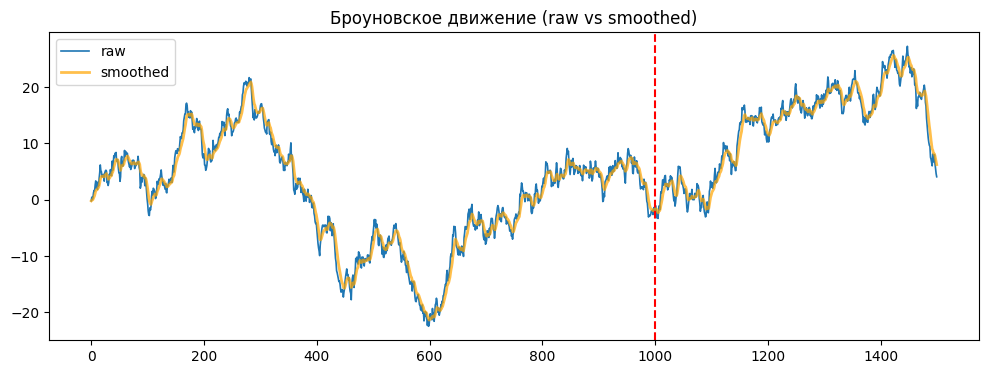

Naive        | Profit:    +0.00 | MSE:   0.9509 | MAE:   0.7862 | ME:  -0.0122
ARIMA        | Profit:    -0.68 | MSE: 288.6927 | MAE:  15.1419 | ME: -15.1194
LR           | Profit:   -21.21 | MSE:   2.0124 | MAE:   1.1346 | ME:  -0.0988
XGB          | Profit:   -11.68 | MSE:   5.2527 | MAE:   1.6674 | ME:  -0.7796
Holt         | Profit:    +2.04 | MSE: 303.9591 | MAE:  15.5316 | ME: -15.5102
LR_Features  | Profit:   +27.79 | MSE:   0.9731 | MAE:   0.7961 | ME:  -0.0164
XGB_Features | Profit:    +0.56 | MSE:   6.7961 | MAE:   1.8644 | ME:  -1.1688

ОБРАБОТКА: Геометрическое Броуновское


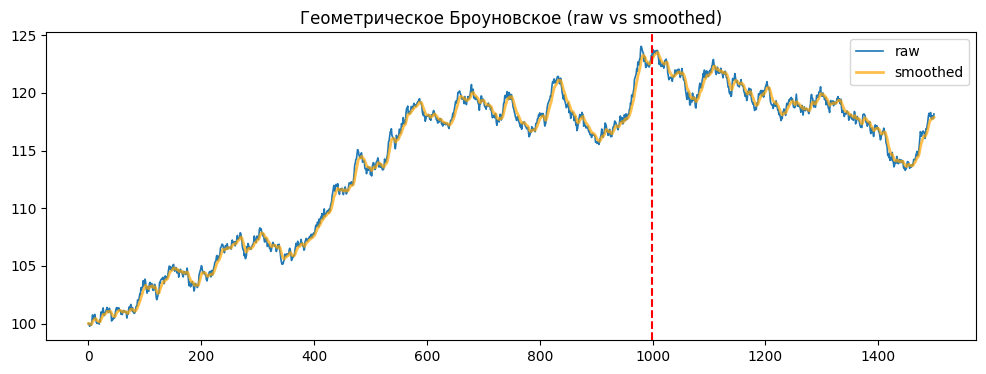

Naive        | Profit:    +0.00 | MSE:   0.0985 | MAE:   0.2529 | ME:   0.0101
ARIMA        | Profit:    -2.92 | MSE:  25.3554 | MAE:   4.4209 | ME:   4.4087
LR           | Profit:    +7.86 | MSE:   0.1939 | MAE:   0.3499 | ME:   0.0327
XGB          | Profit:    +4.34 | MSE:   0.2342 | MAE:   0.3813 | ME:  -0.0223
Holt         | Profit:    -2.92 | MSE: 133.2765 | MAE:  10.1040 | ME:  10.0936
LR_Features  | Profit:    +5.55 | MSE:   0.1011 | MAE:   0.2560 | ME:   0.0119
XGB_Features | Profit:    +9.03 | MSE:   0.2208 | MAE:   0.3708 | ME:  -0.0166

ОБРАБОТКА: Орнштейн-Уленбек


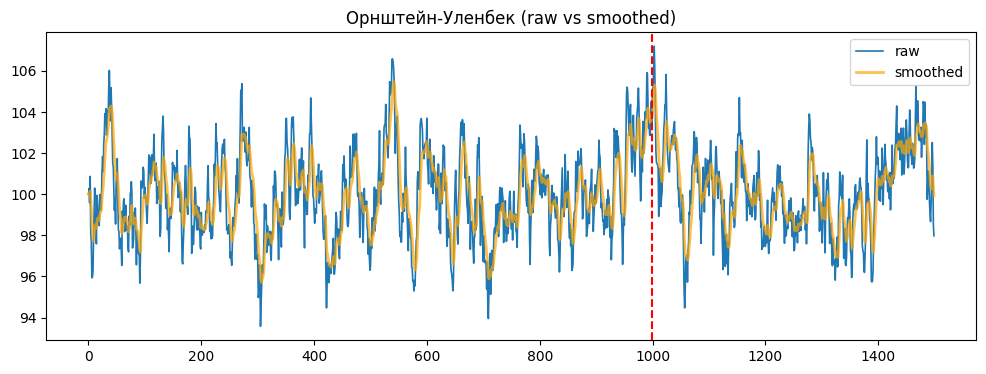

Naive        | Profit:    +0.00 | MSE:   1.0744 | MAE:   0.8393 | ME:   0.0105
ARIMA        | Profit:   +25.24 | MSE:  15.1479 | MAE:   3.4012 | ME:   3.2880
LR           | Profit:   +39.83 | MSE:   1.8755 | MAE:   1.0983 | ME:   0.0021
XGB          | Profit:   +42.93 | MSE:   2.0790 | MAE:   1.1592 | ME:   0.0268
Holt         | Profit:   +12.36 | MSE:  19.5357 | MAE:   3.9658 | ME:   3.8793
LR_Features  | Profit:   -28.45 | MSE:   1.1265 | MAE:   0.8617 | ME:   0.0142
XGB_Features | Profit:   +48.17 | MSE:   1.3140 | MAE:   0.9122 | ME:   0.0076


In [199]:
n_steps = 1500
train_size = 1000
lags = 15
dt = 1

processes = {
    'Броуновское движение': generate_brownian_motion,
    'Геометрическое Броуновское': generate_geometric_brownian_motion,
    'Орнштейн-Уленбек': generate_ou_process
}

results = []

for name, gen_func in processes.items():
    print(f"\n{'='*60}")
    print(f"ОБРАБОТКА: {name}")
    print(f"{'='*60}")

    if name == 'Геометрическое Броуновское':
        data = gen_func(n_steps, mu=0.2/n_steps, sigma=0.1/np.sqrt(n_steps), S0=100, dt=dt)
    elif name == 'Орнштейн-Уленбек':
        data = gen_func(n_steps, theta=0.1, mu=100.0, sigma=1, X0=100, dt=dt)
    else:
        data = gen_func(n_steps, sigma=1, dt=dt)

    train_data = data[:train_size]
    test_data_full = data[train_size - 1:]

    plt.figure(figsize=(12,4))
    plt.plot(data, label="raw", linewidth=1.2)

    plt.plot(
        smooth_series(data),
        label="smoothed",
        color="orange",
        alpha=0.7,
        linewidth=2
    )

    plt.axvline(train_size - 1, color='red', linestyle='--')
    plt.legend()
    plt.title(name + " (raw vs smoothed)")
    plt.show()


    X, y, idx = create_lagged_dataset(data, lags=lags)
    train_end_idx = train_size - lags

    X_train = X.iloc[:train_end_idx]
    y_train = y.iloc[:train_end_idx]
    X_test = X.iloc[train_end_idx - 1:]

    row = {"Процесс": name}

    for model_name in ["Naive", "ARIMA", "LR", "XGB", "Holt", "LR_Features", "XGB_Features"]:
        preds = run_model(
            model_name, 
            train_data, 
            test_data_full,
            mode="raw",
            X_train=X_train, 
            y_train=y_train,
            X_test=X_test
        )
        profit, _, mae, mse, me = simulate_trading(test_data_full, preds)
        row[model_name] = round(profit, 2)
        print(f"{model_name:12} | Profit: {profit:+8.2f} | MSE: {mse:8.4f} | MAE: {mae:8.4f} | ME: {me:8.4f}")

    results.append(row)


In [200]:
def run_multiple_simulations(n=100, mode_list=["raw", "smooth"]):
    n_steps = 1500
    train_size = 1000
    lags = 50
    dt = 1
    
    processes = {
        'Броуновское движение': generate_brownian_motion,
        'Геометрическое Броуновское': generate_geometric_brownian_motion,
        'Орнштейн-Уленбек': generate_ou_process
    }
    
    metrics = {}
    for name in processes:
        metrics[name] = {}
        for m in MODEL_REGISTRY:
            metrics[name][m] = {'profit': [], 'MSE': [], 'MAE': [], 'ME': []}
            for mode in mode_list:
                key = f"{mode.capitalize()}_{m}" if mode != "raw" else m
                metrics[name][key] = {'profit': [], 'MSE': [], 'MAE': [], 'ME': []}

    print(f"Запуск {n} симуляций...")

    for name, gen_func in processes.items():
        print(f"   {name}: ", end="")
        
        for sim in range(n):
            if sim % max(1, n // 10) == 0:
                print(sim, end=", ")

            if name == 'Геометрическое Броуновское':
                data = gen_func(n_steps, mu=0.2/n_steps, sigma=0.1/np.sqrt(n_steps), S0=100, dt=dt)
            elif name == 'Орнштейн-Уленбек':
                data = gen_func(n_steps, theta=0.1, mu=100.0, sigma=1, X0=100, dt=dt)
            else:
                data = gen_func(n_steps, sigma=1, dt=dt)

            train_data = data[:train_size]
            test_data_full = data[train_size - 1:]

            X, y, _ = create_lagged_dataset(data, lags=lags)
            train_end_idx = train_size - lags
            X_train, y_train = X.iloc[:train_end_idx], y.iloc[:train_end_idx]
            X_test = X.iloc[train_end_idx - 1:]

            for mode in mode_list:
                for model_name in MODEL_REGISTRY:
                    preds = run_model(
                        model_name,
                        train_data,
                        test_data_full,
                        mode=mode,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test
                    )
                    profit, _, mae, mse, me = simulate_trading(test_data_full, preds)
                    key = f"{mode.capitalize()}_{model_name}" if mode != "raw" else model_name
                    metrics[name][key]['profit'].append(profit)
                    metrics[name][key]['MSE'].append(mse)
                    metrics[name][key]['MAE'].append(mae)
                    metrics[name][key]['ME'].append(me)

        print()

    print("\n" + "="*60)
    print(f"СРЕДНИЕ МЕТРИКИ ЗА {n} СИМУЛЯЦИЙ")
    print("="*60)
    
    for name in processes:
        print(name + ":")
        for m in metrics[name]:
            mean_profit = np.mean(metrics[name][m]['profit'])
            mean_mse = np.mean(metrics[name][m]['MSE'])
            mean_mae = np.mean(metrics[name][m]['MAE'])
            mean_me = np.mean(metrics[name][m]['ME'])
            print(f"{m:20} | Profit: {mean_profit:+8.2f} | MSE: {mean_mse:8.4f} | MAE: {mean_mae:8.4f} | ME: {mean_me:8.4f}")
        print()

    return metrics


In [202]:
x = run_multiple_simulations(500)

Запуск 500 симуляций...
   Броуновское движение: 0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 
   Геометрическое Броуновское: 0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 
   Орнштейн-Уленбек: 0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 

СРЕДНИЕ МЕТРИКИ ЗА 500 СИМУЛЯЦИЙ
Броуновское движение:
Naive                | Profit:    +0.00 | MSE:   0.9926 | MAE:   0.7949 | ME:   0.0014
Smooth_Naive         | Profit:    +0.00 | MSE:   0.9926 | MAE:   0.7949 | ME:   0.0014
ARIMA                | Profit:    +0.88 | MSE: 243.5964 | MAE:  11.6852 | ME:  -0.3091
Smooth_ARIMA         | Profit:    +1.08 | MSE: 243.7527 | MAE:  11.6939 | ME:  -0.3130
LR                   | Profit:    -0.11 | MSE:   2.0569 | MAE:   1.1441 | ME:   0.0015
Smooth_LR            | Profit:    -0.35 | MSE:   3.1333 | MAE:   1.4117 | ME:   0.0070
XGB                  | Profit:    -0.30 | MSE:  85.2426 | MAE:   5.0424 | ME:   0.1682
Smooth_XGB           | Profit:    -0.74 | MSE:  74.2835 | MAE:   4.7020 | ME:   0.1713
Hol